# Problem Set 4: Hybrid Optimization

AI 211 | 2nd Sem AY 2023-2024

Students:  
Joshua Cantor  
Michael Spencer Quinto


In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import timeit

from numpy import ndarray
from typing import Callable

The Bohachevsky Function 1st variant is a commonly used test function in optimization, notable
for its simplicity yet challenging landscape. The function is defined as:

$$f_1(x, y) = x^2 + 2y^2 - 0.3\cos(3\pi x) - 0.4\cos(4\pi y) + 0.7$$

The graph is also shown in 3D below.


In [14]:
# Define Bohachevsky function f1 and its gradient
def f1(x: ndarray, y: ndarray):
    """Calculate the value of the Bohachevsky function f1 at given points (x, y).

    The Bohachevsky function f1 is a common test function for optimization algorithms.
    It is a two-dimensional function with several local minima.

    Args:
        x (ndarray): The x-coordinate(s) at which to evaluate the function.
        y (ndarray): The y-coordinate(s) at which to evaluate the function.

    Returns:
        ndarray: The value of the Bohachevsky function f1 at the specified coordinates.
    """
    return (
        x**2
        + 2 * y**2
        - 0.3 * np.cos(3 * np.pi * x)
        - 0.4 * np.cos(4 * np.pi * y)
        + 0.7
    )


def grad_f1(x: ndarray, y: ndarray):
    """Calculate the gradient of the Bohachevsky function f1 at given points (x, y).

    The gradient of a function gives the direction of the steepest ascent.
    This function returns the partial derivatives of f1 with respect to x and y.

    Args:
        x (ndarray): The x-coordinate(s) at which to evaluate the gradient.
        y (ndarray): The y-coordinate(s) at which to evaluate the gradient.

    Returns:
        ndarray: An array containing the partial derivatives [df_dx, df_dy].
    """

    # Compute the partial derivative of f1 with respect to x
    df_dx = 2 * x + 0.9 * np.pi * np.sin(3 * np.pi * x)
    df_dy = 4 * y + 1.6 * np.pi * np.sin(4 * np.pi * y)  # wrt to y

    return np.array([df_dx, df_dy])


def hessian_f1(x: ndarray, y: ndarray):
    """Calculate the Hessian matrix of the Bohachevsky function f1 at given points (x, y).

    The Hessian matrix is a square matrix of second-order partial derivatives of a function.
    It provides information about the local curvature of the function.

    Args:
        x (ndarray): The x-coordinate(s) at which to evaluate the Hessian matrix.
        y (ndarray): The y-coordinate(s) at which to evaluate the Hessian matrix.

    Returns:
        ndarray: A 2x2 array representing the Hessian matrix at the specified coordinates.
    """
    d2f_dx2 = 2 + 2.7 * (np.pi**2) * np.cos(3 * np.pi * x)
    d2f_dy2 = 4 + 6.4 * (np.pi**2) * np.cos(4 * np.pi * y)
    d2f_dxdy = 0

    return np.array([[d2f_dx2, d2f_dxdy], [d2f_dxdy, d2f_dy2]])

In [15]:
# Create a grid of points
x = np.linspace(-1, 1, 400)
y = np.linspace(-1, 1, 400)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)

# Plot the function in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, Z, cmap="jet", edgecolor="none")
plt.title("Bohachevsky Function")
plt.xlabel("x")
plt.ylabel("y")
ax.set_zlabel("f(x, y)")
plt.show()

# Trust Region Newton method

The Trust Region Newton method is an optimization algorithm that balances between local quadratic approximations and global models to efficiently handle complex, non-linear functions. By iteratively adjusting the size of the trust region, it ensures robust convergence to optimal solutions even in challenging problem spaces.


In [16]:
def trust_region_step(grad: ndarray, hess: ndarray, delta: float = 1.0):
    """Compute the trust region step for an optimization problem.

    The trust region method is an iterative optimization technique that restricts
    the step size based on a specified trust region radius. This function calculates
    the step direction and magnitude within the given trust region.

    Args
        grad (ndarray): The gradient of the objective function at the current point.
        hess (ndarray): The Hessian matrix (second-order partial derivatives) of the objective function at the current point.
        delta (float): The radius of the trust region. Default is 1.0.

    Returns:
        ndarray: The step vector within the trust region.
    """
    try:
        # Compute the Newton step using the inverse of the Hessian
        p = -np.linalg.inv(hess).dot(grad)
    except np.linalg.LinAlgError:
        # If the Hessian is not invertible, use the negative gradient direction
        p = -grad

    # Check if the computed step is outside the trust region
    if np.linalg.norm(p) > delta:
        # Scale the step to lie within the trust region boundary
        p = delta * p / np.linalg.norm(p)
    return p


# Example usage and testing
# grad = np.array([1.0, 2.0])
# hess = np.array([[5.0, 1.0], [1.0, 3.0]])
# delta = 1.0
# step = trust_region_step(grad, hess, delta)
# print(step)

In [17]:
def newton_method(
    f: Callable,
    grad_f: Callable,
    hessian_f: Callable,
    x0: ndarray,
    tol: float = 1e-6,
    max_iter: int = 1000,
):
    """Perform Newton's method for optimization with a trust region approach.

    Newton's method is an iterative optimization technique that uses the gradient and Hessian
    of the objective function to find the minimum. This implementation includes a trust region
    step to handle cases where the Hessian is not positive definite or not invertible.

    Args:
        f (Callable): The objective function to minimize.
        grad_f (Callable): The gradient of the objective function.
        hessian_f (Callable): The Hessian matrix of the objective function.
        x0 (ndarray): The initial guess for the minimizer.
        tol (float): The tolerance for the norm of the gradient. Default is 1e-6.
        max_iter (int): The maximum number of iterations. Default is 1000.

    Returns:
        tuple: A tuple containing:
            - ndarray: The path of iterates as an array of shape (num_iter, len(x0)).
            - int: The number of function evaluations.
            - int: The number of gradient evaluations.
    """
    x_k = np.array(x0)
    path = [x_k.copy()]
    function_evals = 0
    gradient_evals = 0

    for k in range(max_iter):
        grad_k = grad_f(x_k[0], x_k[1])
        gradient_evals += 1

        # check for convergence
        if np.linalg.norm(grad_k) < tol or np.isnan(np.linalg.norm(grad_k)):
            break

        hess = hessian_f(x_k[0], x_k[1])
        epsilon_k = trust_region_step(grad_k, hess)

        # Update the current point
        x_k = x_k + (x_k * epsilon_k)
        function_evals += 1
        path.append(x_k.copy())

    return np.array(path), function_evals, gradient_evals

# Steepest Descent with Armijo's Rule

The Steepest Descent method with Armijo's Rule is a gradient-based optimization technique that ensures efficient convergence by adjusting the step size according to a specific condition. Armijo's Rule dynamically scales the step size to guarantee sufficient decrease in the objective function, improving stability and performance in finding minima.


In [18]:
def armijo_rule(
    f: Callable,
    grad_f: Callable,
    x: ndarray,
    d_k: ndarray,
    epsilon_0: int = 1,
    beta: float = 0.5,
    sigma: float = 10 ** (-4),
):
    """Perform Armijo's rule for backtracking line search.

    Armijo's rule is a condition used in backtracking line search to find a step length that
    sufficiently decreases the objective function. This implementation iteratively reduces the
    step length until the condition is satisfied.

    Args:
        f (Callable): The objective function to minimize.
        grad_f (Callable): The gradient of the objective function.
        x (ndarray): The current point in the parameter space.
        d_k (ndarray): The search direction.
        epsilon_0 (float): The initial step length. Default is 1.0.
        beta (float): The factor by which to decrease the step length. Default is 0.5.
        sigma (float): The sufficient decrease parameter. Default is 10^(-4).

    Returns:
        float: The step length that satisfies Armijo's condition.
    """

    # Evaluate the objective function at the current point
    fx = f(x[0], x[1])
    grad_fx = grad_f(x[0], x[1])

    # Initialize the step length
    epsilon = epsilon_0

    # Iteratively reduce the step length until Armijo's condition is satisfied
    while True:

        # Check if the objective function at the new point satisfies Armijo's condition
        if f(
            x[0] + epsilon * d_k[0], x[1] + epsilon * d_k[1]
        ) <= fx + sigma * epsilon * np.dot(grad_fx, d_k):
            break

        epsilon *= beta

    return epsilon


# Example usage and testing
# f = lambda x, y: x**2 + y**2
# grad_f = lambda x, y: np.array([2*x, 2*y])
# x = np.array([1.0, 1.0])
# d_k = np.array([-1.0, -1.0])
# step_length = armijo_rule(f, grad_f, x, d_k)
# print("Step length:", step_length)

In [19]:
def steepest_descent(
    f: Callable, grad_f: Callable, x0: ndarray, tol: float = 1e-6, max_iter: int = 1000
):
    """Perform the steepest descent optimization method with Armijo's rule for step size selection.

    The steepest descent method is an iterative optimization technique that moves in the direction
    of the negative gradient. This implementation uses Armijo's rule for backtracking line search
    to find an appropriate step size.

    Args:
        f (Callable): The objective function to minimize.
        grad_f (Callable): The gradient of the objective function.
        x0 (ndarray): The initial guess for the minimizer.
        tol (float): The tolerance for the norm of the gradient. Default is 1e-6.
        max_iter (int): The maximum number of iterations. Default is 1000.

    Returns:
        tuple: A tuple containing:
            - ndarray: The path of iterates as an array of shape (num_iter, len(x0)).
            - int: The number of function evaluations.
            - int: The number of gradient evaluations.
    """
    x_k = np.array(x0)
    path = [x_k.copy()]  # Store the path of iterates
    function_evals = 0
    gradient_evals = 0

    for k in range(max_iter):
        grad_k = grad_f(x_k[0], x_k[1])
        gradient_evals += 1

        if np.linalg.norm(grad_k) < tol or np.isnan(np.linalg.norm(grad_k)):
            break

        d_k = -grad_k  # # Determine the search direction (negative gradient)
        epsilon_k = armijo_rule(f, grad_f, x_k, d_k)  ## change this to Armijo

        # Update the current point
        x_k = x_k + (epsilon_k * d_k)
        function_evals += 1
        path.append(x_k.copy())

    return np.array(path), function_evals, gradient_evals


# x0 = np.array([1.0, 1.0])
# path, function_evals, gradient_evals = steepest_descent(f, grad_f, x0)
# print("Path:", path)
# print("Function evaluations:", function_evals)
# print("Gradient evaluations:", gradient_evals)

# Hybrid Method

The Hybrid Method combines the Trust Region Newton method with the Steepest Descent method incorporating Armijo's Rule to leverage the strengths of both approaches. This hybrid approach utilizes the robust local convergence properties of the Trust Region Newton method while integrating the global search capabilities of the Steepest Descent method. By dynamically adjusting between these methods based on the problem's characteristics, it ensures efficient and stable convergence even for complex, non-linear optimization problems. The integration of Armijo's Rule further enhances the step size control, ensuring adequate progress at each iteration.


In [20]:
# Hybrid method
def hybrid_method(
    f: Callable,
    grad_f: Callable,
    hessian_f: Callable,
    x0: ndarray,
    use_armijo: bool = False,
    tol: float = 1e-6,
    max_iter: int = 1000,
):
    """Perform a hybrid optimization method using steepest descent with Armijo's rule and Newton's method with a trust region.

    This method alternates between steepest descent and Newton's method, using Armijo's rule for step size selection in
    the steepest descent phase and a trust region approach in the Newton's method phase.

    Args:
        f (Callable): The objective function to minimize.
        grad_f (Callable): The gradient of the objective function.
        hessian_f (Callable): The Hessian matrix of the objective function.
        x0 (ndarray): The initial guess for the minimizer.
        use_armijo (bool): Flag to start with Armijo's rule or not. Default is False.
        tol (float): The tolerance for the norm of the gradient. Default is 1e-6.
        max_iter (int): The maximum number of iterations. Default is 1000.

    Returns:
        tuple: A tuple containing:
            - ndarray: The path of iterates as an array of shape (num_iter, len(x0)).
            - int: The number of function evaluations.
            - int: The number of gradient evaluations.
    """

    x_k = np.array(x0)
    path = [x_k.copy()]
    function_evals = 0
    gradient_evals = 0

    for k in range(max_iter):
        grad_k = grad_f(x_k[0], x_k[1])  # Evaluate the gradient at the current point
        gradient_evals += 1

        if np.linalg.norm(grad_k) < tol or np.isnan(np.linalg.norm(grad_k)):
            break

        d_k = -grad_k

        if use_armijo:
            epsilon_k = armijo_rule(f, grad_f, x_k, d_k, 0.3)
            x_k = x_k + (epsilon_k * d_k)
        else:
            hess = hessian_f(x_k[0], x_k[1])
            epsilon_k = trust_region_step(grad_k, hess)
            x_k = x_k + (x_k * epsilon_k)
            use_armijo = True
        function_evals += 1
        path.append(x_k.copy())

    return np.array(path), function_evals, gradient_evals


# x0 = np.array([1.0, 1.0])
# x0 = np.array([0.53, 0.3])
# path, function_evals, gradient_evals = hybrid_method(f, grad_f, hessian_f, x0)
# print("Path:", path)
# print("Function evaluations:", function_evals)
# print("Gradient evaluations:", gradient_evals)

## Results and Graphs both in 2D and 3D

The plot and the evaluation data provided a comparative analysis of three optimization methods
applied to the Bohachevsky function (first function):

- Trust Region Newton method
- Steepest Descent with Armijo’s Rule
- Hybrid Method

The results demonstrate the performance and efficiency of each method in terms of path taken,
computation time, and the number of function and gradient evaluations


In [21]:
# Initial point
x0 = np.array([1.5, 1.5])

# Plot the results
X, Y = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
Z = f1(X, Y)

# Measure and run newton method
st_newton = timeit.default_timer()
path_newton, fevals_newton, gevals_newton = newton_method(f1, grad_f1, hessian_f1, x0)
time_newton = timeit.default_timer() - st_newton

# Measure and run Steepest Descent with Armijo's Rule
st_sd_armijo = timeit.default_timer()
path_sd_armijo, fevals_sd_armijo, gevals_sd_armijo = steepest_descent(f1, grad_f1, x0)
time_sd_armijo = timeit.default_timer() - st_sd_armijo

# Measure and run Hybrid Method
st_hybrid = timeit.default_timer()
path_sd_hybrid, fevals_sd_hybrid, gevals_sd_hybrid = hybrid_method(
    f1, grad_f1, hessian_f1, x0, use_armijo=False
)
time_sd_hybrid = timeit.default_timer() - st_hybrid

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.contour(X, Y, Z, levels=50, cmap="jet")
plt.plot(path_newton[:, 0], path_newton[:, 1], "ro-", label="Newton Path")
plt.scatter(x0[0], x0[1], color="green", label="Start Point")
plt.title("Trust Region Newton method Path")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(1, 3, 2)
plt.contour(X, Y, Z, levels=50, cmap="jet")
plt.plot(path_sd_armijo[:, 0], path_sd_armijo[:, 1], "ro-", label="SD Path")
plt.scatter(x0[0], x0[1], color="green", label="Start Point")
plt.title("Steepest Descent Path")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(1, 3, 3)
plt.contour(X, Y, Z, levels=50, cmap="jet")
plt.plot(path_sd_hybrid[:, 0], path_sd_hybrid[:, 1], "ro-", label="Hybrid Path")
plt.scatter(x0[0], x0[1], color="green", label="Start Point")
plt.title("Hybrid Optimization Path")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

print(
    f"Trust Region Newton method: Time={time_newton:.10f}s, Function Evals={fevals_newton}, Gradient Evals={gevals_newton}"
)
print(
    f"Steepest Descent with Armijo's Rule: Time={time_sd_armijo:.10f}s, Function Evals={fevals_sd_armijo}, Gradient Evals={gevals_sd_armijo}"
)
print(
    f"Hybrid Method: Time={time_sd_hybrid:.10f}s, Function Evals={fevals_sd_hybrid}, Gradient Evals={gevals_sd_hybrid}"
)

plt.tight_layout()
plt.show()

Trust Region Newton method: Time=0.0456336110s, Function Evals=1000, Gradient Evals=1000
Steepest Descent with Armijo's Rule: Time=0.0020863690s, Function Evals=26, Gradient Evals=27
Hybrid Method: Time=0.0011170140s, Function Evals=16, Gradient Evals=17


## Graph in 3D


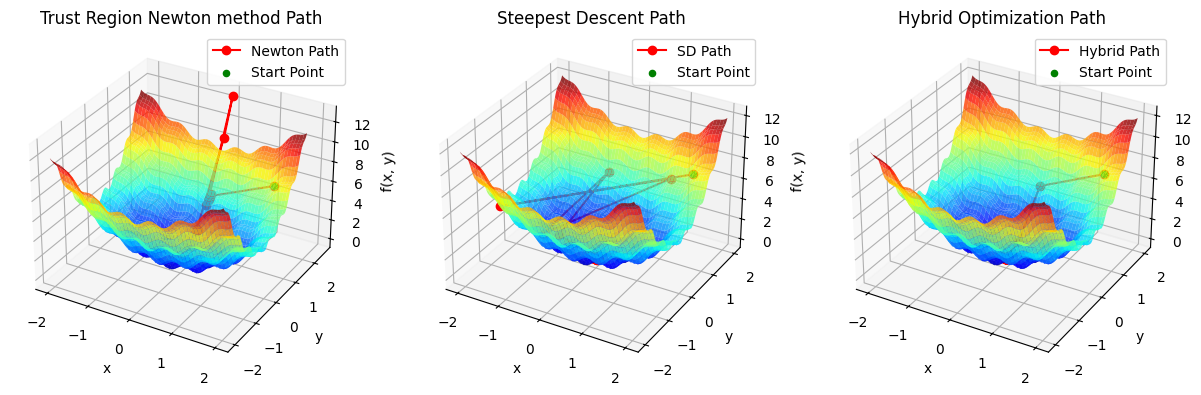

In [22]:
fig = plt.figure(figsize=(15, 5))

# 3D plot for Trust Region Newton method Path
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_surface(X, Y, Z, cmap="jet", alpha=0.8)
ax1.plot(
    path_newton[:, 0],
    path_newton[:, 1],
    f1(path_newton[:, 0], path_newton[:, 1]),
    "ro-",
    label="Newton Path",
)
ax1.scatter(x0[0], x0[1], f1(x0[0], x0[1]), color="green", label="Start Point")
ax1.set_title("Trust Region Newton method Path")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("f(x, y)")
ax1.legend()

# 3D plot for Steepest Descent Path
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_surface(X, Y, Z, cmap="jet", alpha=0.8)
ax2.plot(
    path_sd_armijo[:, 0],
    path_sd_armijo[:, 1],
    f1(path_sd_armijo[:, 0], path_sd_armijo[:, 1]),
    "ro-",
    label="SD Path",
)
ax2.scatter(x0[0], x0[1], f1(x0[0], x0[1]), color="green", label="Start Point")
ax2.set_title("Steepest Descent Path")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("f(x, y)")
ax2.legend()

# 3D plot for Hybrid Optimization Path
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot_surface(X, Y, Z, cmap="jet", alpha=0.8)
ax3.plot(
    path_sd_hybrid[:, 0],
    path_sd_hybrid[:, 1],
    f1(path_sd_hybrid[:, 0], path_sd_hybrid[:, 1]),
    "ro-",
    label="Hybrid Path",
)
ax3.scatter(x0[0], x0[1], f1(x0[0], x0[1]), color="green", label="Start Point")
ax3.set_title("Hybrid Optimization Path")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("f(x, y)")
ax3.legend()

plt.show()